# SLIC-ed imgs to training set

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage.transform import resize
from matplotlib import image as mpimg
import os
from scipy.misc import imresize

In [3]:
path = '../data/'
pimg = 'train_sample/'
pgt = 'train_maps/'
nfiles = len(os.listdir(path + pimg))
nfiles_maps = len(os.listdir(path + pgt))
print(nfiles, nfiles_maps)

10000 10000


Importing the data:

In [4]:
def load_image(infilename):
    """ Reads images """
    data = mpimg.imread(infilename)
    return data


def load_batch(path, pimg, pgt, nfiles, batch_size=1000):
    
    # sample randomly
    randomise = np.random.choice(nfiles, size=batch_size, replace=False)

    # generate file lists
    print('Reading file names ..')
    filelist = []
    filelist = [os.listdir(path + pimg)[i] for i in randomise]
    gtlist = ['gt_' + filelist[i] for i in range(len(filelist))]
    print('read')
    
    # initialise datasets
    imgs = []
    gts = []

    # read files
    print('Reading ', batch_size, ' files...')
    i = 0
    while i < batch_size:
        name = path + pimg + filelist[i]
        gtname = path + pgt + gtlist[i]
        if name.endswith(".jpg"):
            i += 1
            imgs.append(load_image(name))
            gts.append(load_image(gtname))
    
    imgs = np.asarray(imgs)
    gts = np.asarray(gts)
    print('Read ', i, ' files.')
    print('Check: img size', imgs.shape, '\tgt size', gts.shape)
    return imgs, gts

In [5]:
# get some data
batch_size = 6
imgs, gts = load_batch(path, pimg, pgt, nfiles, batch_size)

Reading file names ..
read
Reading  6  files...
Read  6  files.
Check: img size (6, 768, 768, 3) 	gt size (6, 768, 768)


In [253]:
# safekeeping - sometimes you do dumb things
imsave = np.copy(imgs)
gtsave = np.copy(gts)

In [254]:
# create SLIC megapixels
n_segments = 100
SLIC_list = np.asarray([slic(imgs[i,:], n_segments, compactness=20, sigma=10) for i in range(imgs.shape[0])])

In [255]:
# DEBUG
SLIC_list.shape
print(SLIC_list[1,:])

[[ 0  0  0 ...  9  9  9]
 [ 0  0  0 ...  9  9  9]
 [ 0  0  0 ...  9  9  9]
 ...
 [91 91 91 ... 96 96 96]
 [91 91 91 ... 96 96 96]
 [91 91 91 ... 96 96 96]]


In [256]:
# find smallest patch around each pixel - function
def box(seg, i):
    xind = np.nonzero(seg.ravel('C') == i)
    [xmax, _ ] = np.unravel_index(np.max(xind), seg.shape, order = 'C')
    [xmin, temp] = np.unravel_index(np.min(xind), seg.shape, order = 'C')
    yind = np.nonzero(seg.ravel('F') == i)
    [temp, ymax] = np.unravel_index(np.max(yind), seg.shape, order = 'F')
    [temp, ymin] = np.unravel_index(np.min(yind), seg.shape, order = 'F')
    return np.array([xmax, ymax, xmin, ymin])

In [257]:
# initialise boxes
boxes = np.empty((batch_size,0)).tolist()
# run box function to find all superpixel patches sizes
for i in range(batch_size):
    [boxes[i].append(box(SLIC_list[i,:],j)) for j in range(np.max(SLIC_list[i,:]))]

In [267]:
# DEBUG
# size of boxes last dimension should be 4 (4 edges)
print(len(boxes), len(boxes[0]), len(boxes[0][0]))

6 99 4


## LABELS

Study case: image 'gt_0a20d8143.jpg'

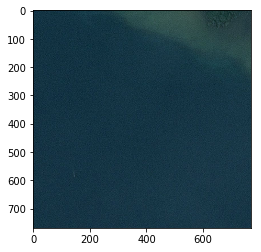

In [144]:
filename = '0a20d8143.jpg'
st = mpimg.imread(path + pimg + filename)
plt.imshow(st)
plt.show()

mask:

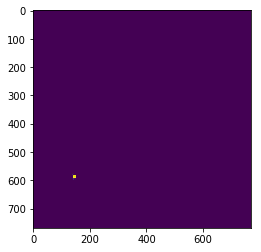

In [145]:
filename = 'gt_0a20d8143.jpg'
gt = mpimg.imread(path + pgt+filename)
plt.imshow(gt)
plt.show()

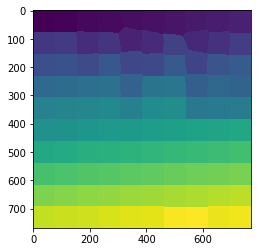

In [138]:
SLIC = slic(st, n_segments, compactness=20, sigma=10)
plt.imshow(SLIC)
plt.show()

In [139]:
# finding the patch that contain the boat
for i in range(99):
    print(i, np.sum(gt[SLIC == i] > 125))

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 0
52 0
53 0
54 0
55 0
56 0
57 0
58 0
59 0
60 0
61 0
62 0
63 0
64 0
65 0
66 0
67 0
68 0
69 0
70 0
71 86
72 0
73 0
74 0
75 0
76 0
77 0
78 0
79 0
80 0
81 0
82 0
83 0
84 0
85 0
86 0
87 0
88 0
89 0
90 0
91 0
92 0
93 0
94 0
95 0
96 0
97 0
98 0


In [ ]:
#as you can see this value is too small and it will classify this patch as 0
num = np.sum(gt[SLIC == 71] > 125)
denom = gt[SLIC == 71].size
float(num)/float(denom)

In [148]:
#that's why we need this term as well
thres2 = 0.5
size_true = np.sum(gt > 125)
print(num/size_true)
num/size_true > thres2

1.0


True

In [218]:
# create training set for gts
thres1 = 0.25
thres2 = 0.5
def patch_cat(gt, SLIC, i, thres1, thres2):
    num = np.sum(gt[SLIC == i] > 125)
    denom = gt[SLIC == i].size
    size_true = np.sum(gt > 125)
    if float(num)/float(denom)>thres1:
        return 1
    else:
        if float(size_true) > 0 and float(num)/float(size_true) > thres2:
            return 1
        else: return 0

In [269]:
# populate y_train using patch_cat
thres1 = 0.2
thres2 = 0.2
y_train = np.empty((batch_size,0)).tolist()
for j in range(batch_size):
    [y_train[j].append(patch_cat(gts[j,:], SLIC_list[j,:], i, thres1, thres2)) for i in range(np.max(SLIC_list[j,:]))]

In [270]:
# creating training set for x
final_size = 80
def xpatchify(img, SLIC, box, i):
    [inda, indb] = np.nonzero(SLIC!=i)
    imtemp = np.copy(img)
    imtemp[inda,indb,:] = 0
    x_temp = imtemp[int(box[2]):int(box[0]), 
                 int(box[3]):int(box[1])]
    x_train = resize(x_temp, (80,80))
    return(x_train)

In [272]:
# LIST
# initialising x_train
x_train = np.empty((batch_size,0)).tolist()
# populating x_train
for i in range(batch_size):
    for j in range(np.max(SLIC_list[i,:])):
        x_train[i].append(xpatchify(imgs[i,:], SLIC_list[i,:], boxes[i][j], j))

/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [ ]:
### FINAL RESULTS
#y_train
#x_train
print(y_train.shape,x_train.shape)

In [ ]:
# DEPRECATED

# initialise boxes
boxes = np.zeros((batch_size, n_segments, 4))
# run box function to find all superpixel patches sizes
for i in range(batch_size):
    for j in range(n_segments):
        # sometimes we get less than n_segment boxes
        try:
            boxes[i,j,:] = box(SLIC_list[i,:],j)
        except ValueError:
            boxes[i,j,:] = np.array([0,0,0,0])

def patch_cat_old(gt, SLIC, i, thres):
    num = np.sum(gt[SLIC == i] > 125)
    denom = gt[SLIC == i].size
    if float(num)/float(denom)>thres:
        return 1
    else:
        return 0

# NUMPY
#
# initialise y_train - setting y to -1 for noon-existing patches
y_train = np.zeros((10, 100))-1
# populate y_train using patch_cat
thres1 = 0.25
thres2 = 0.2
for j in range(batch_size):
    for i in range(np.max(SLIC_list[j,:])):
        y_train[j,i] = patch_cat(gts[j,:], SLIC_list[j,:], i, thres1, thres2)

# NUMPY
#
# initialising x_train
x_train = np.zeros((batch_size,
                   n_segments,
                   final_size,final_size,3))
# populating x_train
for i in range(batch_size):
    for j in range(np.max(SLIC_list[i,:])):
        x_train[i,j,:] = xpatchify(imgs[i,:], SLIC_list[i,:], boxes[i,j,:], j)
print(x_train.shape)

### STUDY

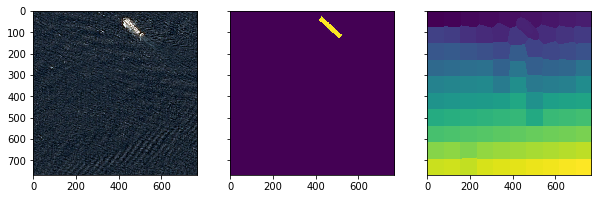

In [199]:
gt = gts[0]
fig, ax = plt.subplots(1, 3, figsize=(10, 10), sharex=True, sharey=True)
ax[0].imshow(imgs[0])
ax[1].imshow(gts[0])
ax[2].imshow(SLIC_list[0,:])
plt.show()

In [203]:
num = np.sum(gt[SLIC_list[0] == 9] > 125)
denom = gt[SLIC_list[0] == 9].size
print(float(num)/float(denom))
size_true = np.sum(gt > 125)
print(num/size_true)

0.22990543735224586
0.2729824561403509


In [127]:
#
# DEBUG
#
# checking
print(y_train.shape, np.nonzero(y_train[5,:]>0))

(10, 100) (array([], dtype=int64),)


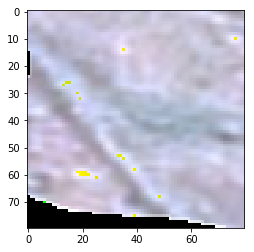

In [143]:
#
# DEBUG
#
# checking
plt.imshow(x_train[9,10,:])
#plt.imshow(xpatchify(imgs[9,:], SLIC[9,:], boxes[9,78,:], 78))#x_train[5,78,:])
plt.show()

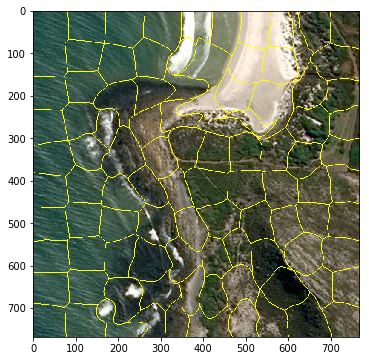

In [139]:
#
# DEBUG
#
# checking
i = 9
plt.figure(figsize=(6,6))
plt.imshow(mark_boundaries(imgs[i,:], SLIC[i,:]))
plt.show()

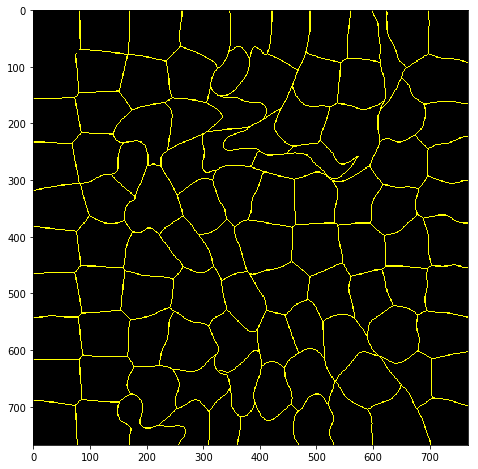

In [141]:
#
# DEBUG
#
# checking
plt.figure(figsize=(8,8))
plt.imshow(mark_boundaries(gts[i,:], SLIC[i,:]))
plt.show()

# TESTING CODE

In [6]:
import os
import numpy as np
from matplotlib import image as mpimg
def load_image(infilename):
    """ Reads images """
    data = mpimg.imread(infilename)
    return data


def load_batch(path, pimg, pgt, nfiles, batch_size=1000):
    # sample randomly
    randomise = np.random.choice(nfiles, size=batch_size, replace=False)
    # generate file lists
    print('Reading file names ..')
    filelist = []
    filelist = [os.listdir(path + pimg)[i] for i in randomise]
    gtlist = ['gt_' + filelist[i] for i in range(len(filelist))]
    print('read')
    # initialise datasets
    imgs = []
    gts = []
    # read files
    print('Reading ', batch_size, ' files...')
    i = 0
    while i < batch_size:
        name = path + pimg + filelist[i]
        gtname = path + pgt + gtlist[i]
        if name.endswith(".jpg"):
            i += 1
            imgs.append(load_image(name))
            gts.append(load_image(gtname))

    imgs = np.asarray(imgs)
    gts = np.asarray(gts)
    print('Read ', i, ' files.')
    print('Check: img size', imgs.shape, '\tgt size', gts.shape)
    return imgs, gts

In [140]:
import numpy as np
from skimage.segmentation import slic
from skimage.transform import resize
import os

def box(seg, i):
    xind = np.nonzero(seg.ravel('C') == i)
    [xmax, _] = np.unravel_index(np.max(xind), seg.shape, order = 'C')
    [xmin, _] = np.unravel_index(np.min(xind), seg.shape, order = 'C')
    yind = np.nonzero(seg.ravel('F') == i)
    [_, ymax] = np.unravel_index(np.max(yind), seg.shape, order = 'F')
    [_, ymin] = np.unravel_index(np.min(yind), seg.shape, order = 'F')
    return np.array([xmax, ymax, xmin, ymin])

def patch_cat(gt, SLIC, i, thres1, thres2):
    num = np.sum(gt[SLIC == i] > 125)
    denom = gt[SLIC == i].size
    size_true = np.sum(gt > 125)
    if float(num)/float(denom)>thres1:
        return 1
    else:
        if float(size_true) > 0 and float(num)/float(size_true) > thres2:
            return 1
        else: return 0

def xpatchify(img, SLIC, boxed, i):
    [inda, indb] = np.nonzero(SLIC!=i)
    imtemp = np.copy(img)
    imtemp[inda,indb,:] = 0
    x_temp = imtemp[int(boxed[2]):int(boxed[0]),
                 int(boxed[3]):int(boxed[1])]
    x_train = resize(x_temp, (80,80))
    return(x_train)

def get_labeled_patches(imgs, gts, n_segments = 100, thres1 = 0.2, thres2 = 0.2):
    """
    Get all the patches from the set of images.
    :param imgs: images
    :param gts: masks
    :param n_segments: max number of patches for image
    :param thres1:
    :param thres2:
    :return:
    """
    n = len(imgs)
    SLIC_list = np.asarray([slic(imgs[i, :], n_segments, compactness=20, sigma=10) for i in range(len(imgs))])

    # initialise boxes
    boxes = np.empty((n, 0)).tolist()
    # run box function to find all superpixel patches sizes
    for i in range(n):
        [boxes[i].append(box(SLIC_list[i, :], j)) for j in range(np.max(SLIC_list[i, :]))]

    patches = np.empty((n, 0)).tolist()
    # populating x_train
    for i in range(n):
        for j in range(np.max(SLIC_list[i, :])):
            patches[i].append(xpatchify(imgs[i, :], SLIC_list[i, :], boxes[i][j], j))

    #labels
    labels = np.empty((n, 0)).tolist()
    for j in range(n):
        [labels[j].append(patch_cat(gts[j, :], SLIC_list[j, :], i, thres1, thres2)) for i in range(np.max(SLIC_list[j, :]))]

    return patches, labels, SLIC_list



path = '../data/'
pimg = 'train_sample/'
pgt = 'train_maps/'
nfiles = len(os.listdir(path + pimg))
imgs, gts = load_batch(path, pimg, pgt, nfiles, 40)
patches, labels, SLIC_list = get_labeled_patches(imgs, gts, n_segments = 100, thres1 = 0.01, thres2 = 0.01)

Reading file names ..
read
Reading  20  files...
Read  20  files.
Check: img size (20, 768, 768, 3) 	gt size (20, 768, 768)


/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


### Train-test split

In [3]:
from sklearn.model_selection import train_test_split

In [15]:
patches_train, patches_dev, labels_train, labels_dev = train_test_split(patches, labels, test_size = 0.2)

In [16]:
print(len(patches_train), len(patches_dev))

8 2


## Fasting up

In [99]:
import numpy as np
from skimage.segmentation import slic
from skimage.transform import resize
import os
import warnings
from matplotlib import image as mpimg
import sys
from numpy import unique
from numpy import random
import time
import parmap

In [352]:
def load_image(infilename):
    """ Reads images """
    data = mpimg.imread(infilename)
    return data

def load_test_batch(path, pimg, nfiles, batch_size=1000):
    # sample randomly
    randomise = np.random.choice(nfiles, size=batch_size, replace=False)
    # generate file lists
    print('Reading file names ..')
    filelist = [os.listdir(path + pimg)[i] for i in randomise]
    print('read')
    # initialise datasets
    imgs = []
    # read files
    print('Reading ', batch_size, ' files...')
    i = 0
    while i < batch_size:
        name = path + pimg + filelist[i]
        i += 1
        if name.endswith(".jpg"):
            imgs.append(load_image(name))

    imgs = np.asarray(imgs)
    print('Read ', i, ' files.')
    print('Check: img size', imgs.shape)
    return imgs


def load_batch(path, pimg, pgt, nfiles, batch_size=1000):
    # sample randomly
    randomise = np.random.choice(nfiles, size=batch_size, replace=False)
    # generate file lists
    print('Reading file names ..')
    filelist = []
    filelist = [os.listdir(path + pimg)[i] for i in randomise]
    gtlist = ['gt_' + filelist[i] for i in range(len(filelist))]
    print('read')
    # initialise datasets
    imgs = []
    gts = []
    # read files
    print('Reading ', batch_size, ' files...')
    i = 0
    while i < batch_size:
        name = path + pimg + filelist[i]
        gtname = path + pgt + gtlist[i]
        if name.endswith(".jpg"):
            i += 1
            imgs.append(load_image(name))
            gts.append(load_image(gtname))

    imgs = np.asarray(imgs)
    gts = np.asarray(gts)
    print('Read ', i, ' files.')
    print('Check: img size', imgs.shape, '\tgt size', gts.shape)
    return imgs, gts

def box(seg):
    list_box = []
    for i in range(np.max(seg)+1):
        xind = np.nonzero(seg.ravel('C') == i)
        [xmax, _] = np.unravel_index(np.max(xind), seg.shape, order = 'C')
        [xmin, _] = np.unravel_index(np.min(xind), seg.shape, order = 'C')
        yind = np.nonzero(seg.ravel('F') == i)
        [_, ymax] = np.unravel_index(np.max(yind), seg.shape, order = 'F')
        [_, ymin] = np.unravel_index(np.min(yind), seg.shape, order = 'F')
        list_box.append(np.array([xmax, ymax, xmin, ymin]))
    return list_box

def patch_cat(gt_SLIC, thres1, thres2):
    gt = gt_SLIC[0]
    SLIC = gt_SLIC[1]
    label_list = []
    for i in range(np.max(SLIC)+1):
        num = np.sum(gt[SLIC == i] > 125)
        denom = gt[SLIC == i].size
        size_true = np.sum(gt > 125)
        if float(num)/float(denom)>thres1:
            label_list.append(1)
        else:
            if float(size_true) > 0 and float(num)/float(size_true) > thres2:
                label_list.append(1)
            else: 
                label_list.append(0)
    return label_list


def xpatchify(img_SLIC_boxed):
    img = img_SLIC_boxed[0]
    SLIC = img_SLIC_boxed[1]
    boxed = img_SLIC_boxed[2]
    list_patches = []
    for i in range(np.max(SLIC)+1):
        [inda, indb] = np.nonzero(SLIC!=i)
        imtemp = np.copy(img)
        imtemp[inda,indb,:] = 0
        x_temp = imtemp[int(boxed[i][2]):int(boxed[i][0]),
                     int(boxed[i][3]):int(boxed[i][1])]
        x_train = resize(x_temp, (80,80))
        list_patches.append(x_train)
    return(list_patches)


def get_labeled_patches(imgs, gts, n_segments = 100, thres1 = 0.1, thres2 = 0.1):
    """
    Get all the patches from the set of images.
    :param imgs: images
    :param gts: masks
    :param n_segments: max number of patches for image
    :param thres1: label = 1 if a proportion bigger than thres1 in the patch is masked as 1
    :param thres2: label = 1 if pixels masked as 1 in patch / total number of pixels masked as 1 in the picture > thres2
    :return: patches: list of patches, size [len(img), n_patches_per_image, 80,80]
    :return: labels: list of labels per each patch, size [len(img), n_patches_per_image]
    """
    n = len(imgs)
    SLIC_list = np.asarray([slic(imgs[i, :], n_segments, compactness=20, sigma=10) for i in range(len(imgs))])

    # run box function to find all superpixel patches sizes
    boxes = parmap.map(box, SLIC_list)
    
    # populating x_train
    patches = parmap.map(xpatchify, zip(imgs,  SLIC_list, boxes))

    #labels
    labels = parmap.map(patch_cat, zip(gts,  SLIC_list), thres1, thres2)
    
    return patches, labels, SLIC_list

def get_patches(imgs, n_segments=100, thres1=0.2, thres2=0.2):
    """
    Get all the patches from the set of images.
    :param imgs: images
    :param gts: masks
    :param n_segments: max number of patches for image
    :param thres1: label = 1 if a proportion bigger than thres1 in the patch is masked as 1
    :param thres2: label = 1 if pixels masked as 1 in patch / total number of pixels masked as 1 in the picture > thres2
    :return: patches: list of patches, size [len(img), n_patches_per_image, 80,80]
    :return: labels: list of labels per each patch, size [len(img), n_patches_per_image]
    """
    n = len(imgs)
    SLIC_list = np.asarray([slic(imgs[i, :], n_segments, compactness=20, sigma=10) for i in range(len(imgs))])

    # run box function to find all superpixel patches sizes
    boxes = parmap.map(box, SLIC_list)

    # populating x_train
    patches = parmap.map(xpatchify, zip(imgs, SLIC_list, boxes))

    return patches, SLIC_list

In [347]:
path = '../data/'
pimg = 'train_sample/'
pgt = 'train_maps/'
nfiles = len(os.listdir(path + pimg))
imgs, gts = load_batch(path, pimg, pgt, nfiles, 10)
patches, labels, SLIC_list = get_labeled_patches(imgs, gts)

Reading file names ..
read
Reading  10  files...
Read  10  files.
Check: img size (10, 768, 768, 3) 	gt size (10, 768, 768)


/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


## mapping the labels in the original image

In [361]:
path = '../data/'
pimg = 'train_sample/'
pgt = 'train_maps/'
nfiles = len(os.listdir(path + pimg))
imgs, gts = load_batch(path, pimg, pgt, nfiles, 10)
patches, labels, SLIC_list = get_labeled_patches(imgs, gts)

# flatten the data
labels_flat = []
[labels_flat.append(l) for patches_labels in labels for l in patches_labels]
labels_flat = np.array(labels_flat)
patches_flat = []
[patches_flat.append(patch) for patches_img in patches for patch in patches_img]
patches_flat = np.array(patches_flat)

Reading file names ..
read
Reading  10  files...
Read  10  files.
Check: img size (10, 768, 768, 3) 	gt size (10, 768, 768)


/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


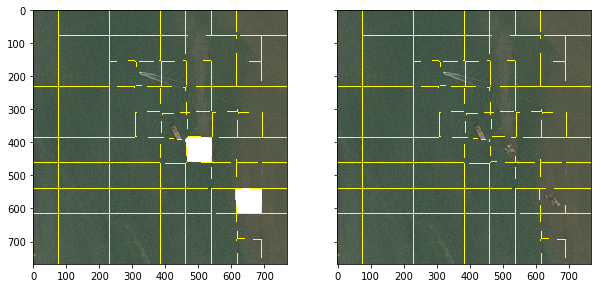

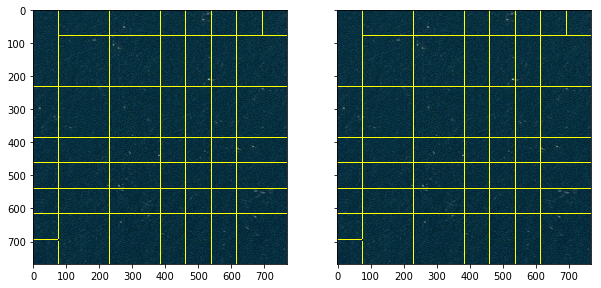

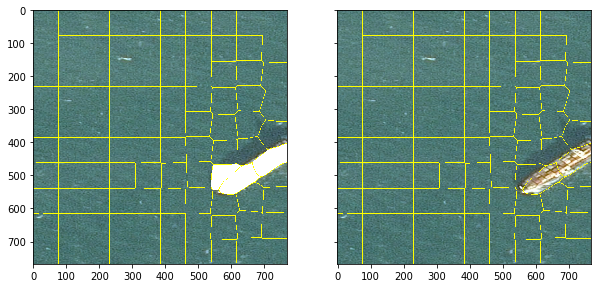

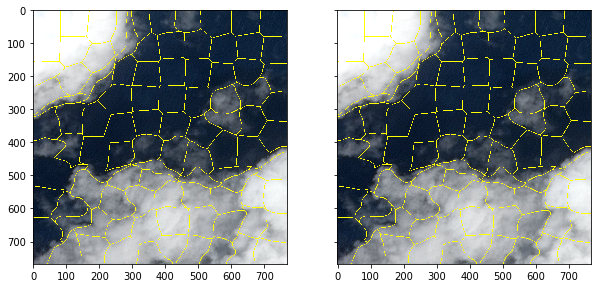

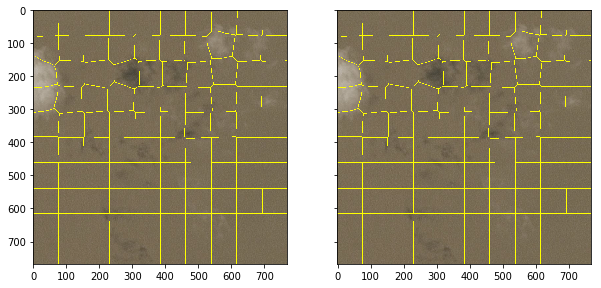

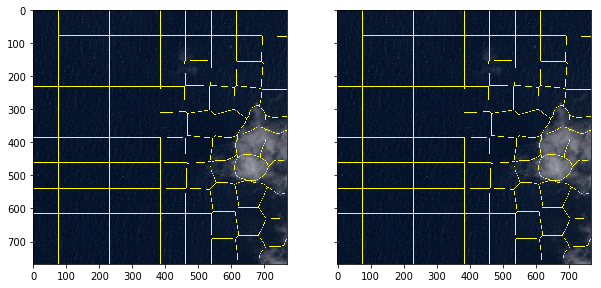

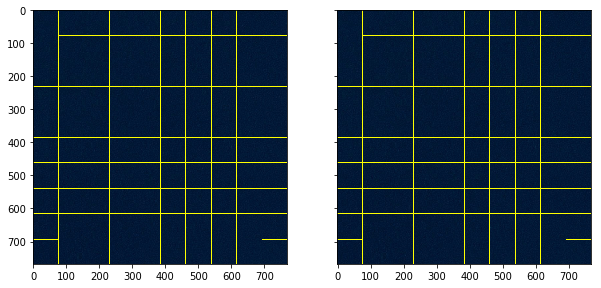

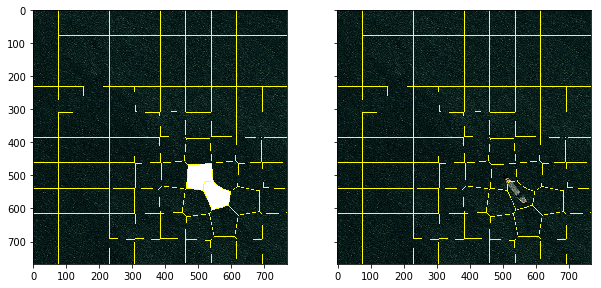

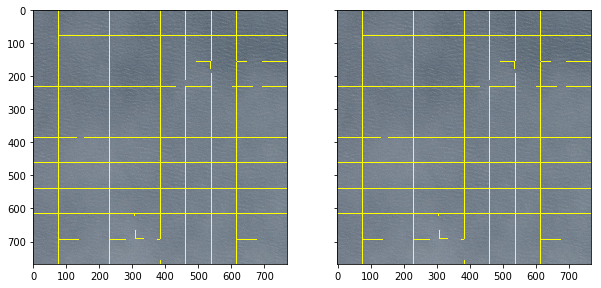

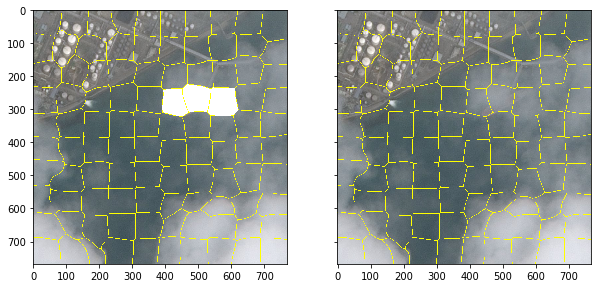

In [362]:
    labels_flat_copy = labels_flat.copy()
    for index in range(10):
        slic_np = np.array(SLIC_list[index])
        values = slic_np.flatten()
        nl = len(set(values))
        label = labels_flat_copy[:nl]
        patches1 = []
        i = 0
        for l in label:
            if l == 1:
                patches1.append(i)
            i += 1
        labels_flat_copy = labels_flat_copy[nl:]

        mm = imgs[index].copy()
        for i in patches1:
            mm[slic_np == i] = 255
        fig, ax = plt.subplots(1, 2, figsize=(10, 10), sharex=True, sharey=True)
        ax[0].imshow(mark_boundaries(mm, SLIC_list[index]))
        ax[1].imshow(mark_boundaries(imgs[index], SLIC_list[index]))
        plt.show()

## flatting the data

In [106]:
# flatten the labels
list_labels = labels.copy()
labels_flat = []
[labels_flat.append(l) for patches_labels in list_labels for l in patches_labels]
#DEBUG
for i in labels_flat:
    if i==1: 
        print("yei")
labels_flat = np.array(labels_flat)
labels_flat.size

yei
yei


990

In [119]:
# flatten the patches
list_patches = patches.copy()
patches_flat = []
[patches_flat.append(patch) for patches_img in list_patches for patch in patches_img]
patches_flat = np.asarray(patches_flat)
patches_flat.shape

990 80


(990, 80, 80, 3)

## Balancing the classes

In [141]:
from numpy import unique
from numpy import random 

def balanced_sample_maker(X, y, random_seed=None):
    """ return a balanced data set by oversampling minority class 
        current version is developed on assumption that the positive
        class is the minority.

    Parameters:
    ===========
    X: {numpy.ndarrray}
    y: {numpy.ndarray}
    """
    uniq_levels = unique(y)
    uniq_counts = {level: sum(y == level) for level in uniq_levels}

    if not random_seed is None:
        random.seed(random_seed)

    # find observation index of each class levels
    groupby_levels = {}
    for ii, level in enumerate(uniq_levels):
        obs_idx = [idx for idx, val in enumerate(y) if val == level]
        groupby_levels[level] = obs_idx
    
    # downsampling on observations of negative label
    sample_size = uniq_counts[0] # number of negative samples
    down_sample_idx = random.choice(groupby_levels[0], size= int(sample_size / 10), replace=True).tolist()
    
    # oversampling on observations of positive label
    over_sample_idx = random.choice(groupby_levels[1], size= int(sample_size / 10), replace=True).tolist()
    balanced_copy_idx = down_sample_idx + over_sample_idx
    random.shuffle(balanced_copy_idx)

    return X[balanced_copy_idx, :], y[balanced_copy_idx]

In [142]:
X, y = balanced_sample_maker(patches_flat, labels_flat)

In [145]:
uniq_levels = unique(y)
uniq_counts = {level: sum(y == level) for level in uniq_levels}
print(uniq_counts)

{0: 98, 1: 98}


In [147]:
len(uniq_levels)

2

## Merging files

In [297]:
import pickle as pkl
import os

"""
This module defines helper functions to load and save data.
"""

def save_obj(obj, name):
    """
    Shortcut function to save an object as pkl
    Args:
        obj: object to save
        name: filename of the object
    """
    with open(name + '.pkl', 'wb') as f:
        pkl.dump(obj, f)


def load_obj(name):
    """
    Shortcut function to load an object from pkl file
    Args:
        name: filename of the object
    Returns:
        obj: object to load
    """
    with open(name + '.pkl', 'rb') as f:
        return pkl.load(f)

def try_to_load_as_pickled_object(filepath):
    """
    This is a defensive way to write pickle.load, allowing for very large files on all platforms
    """
    max_bytes = 2**31 - 1
    input_size = os.path.getsize(filepath)
    bytes_in = bytearray(0)
    with open(filepath, 'rb') as f_in:
        for _ in range(0, input_size, max_bytes):
            bytes_in += f_in.read(max_bytes)
    obj = pkl.loads(bytes_in)
    return obj


In [298]:
list_indices = [0,1000]

In [303]:
tmp1 = try_to_load_as_pickled_object('../data/patches.pkl')

In [305]:
tmp2 = tmp1.copy()

In [311]:
tmp3 = np.append(tmp1, tmp2, axis = 0)

In [313]:
len(tmp2)*2

39380

In [312]:
len(tmp3)

39380

In [ ]:
patches = load_obj('data/patches_' + str(list_indices[0])+ '.pkl')
labels = load_obj('data/labels_patches_' + str(list_indices[0])+ '.pkl')
for d in list_indices:
    tmp1 = load_obj('data/patches_' + str(list_indices[0]))
    patches = np.append(patches, tmp1, axis = 0)
    tmp2 = load_obj('data/labels_patches_' + str(list_indices[0]))
    labels = np.append(labels, tmp2, axis = 0)
save_obj(patches, 'data/patches')
save_obj(labels, 'data/labels_patches')

In [314]:
def process_all_files(list_indices, outputname1='patches.pkl', outputname2='labels_patches'):
    """This function is used to merge several data files from
    several teacher runs.

    Args:
        list_indices:it will merge all the patches_index and labels_patches_index for all index in the list
        outputname: filename where to save the merged data

    Example:
        list_indices = [0,1000,2000,3000, ...]')
    """
    patches = load_obj('data/patches_' + str(list_indices[0]) + '.pkl')
    labels = load_obj('data/labels_patches_' + str(list_indices[0]) + '.pkl')
    for d in list_indices:
        tmp1 = load_obj('data/patches_' + str(list_indices[0]))
        patches = np.append(patches, tmp1, axis=0)
        tmp2 = load_obj('data/labels_patches_' + str(list_indices[0]))
        labels = np.append(labels, tmp2, axis=0)
    save_obj(patches, 'data/patches')
    save_obj(labels, 'data/labels_patches')

In [342]:
l = [0,100,200]
for i in l[1:]:
    print(i)

100
200


In [316]:
data2 = try_to_load_as_pickled_object('../data/patches_1000.pkl')

In [320]:
len(data1)

19712

In [321]:
len(data2)

19692

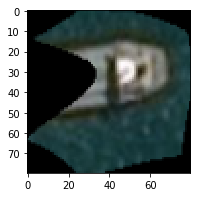

In [341]:
plt.figure(figsize=(3,3))
plt.imshow(data1[17])
plt.show()